In [681]:
from discrete_shocklets import shocklets, kernel_functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import seaborn as sns

In [598]:
import matplotlib.dates as mdates

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plt.rcParams.update({
        'font.size': 10,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'font.family': 'Arial',
        
    })

start_date = datetime(2020,1,1)#lang2freq[keys[0]].index.min()
end_date= datetime(2020,4,30)#lang2freq[keys[0]].index.max()
diff = (start_date-end_date)
date_format = '%b\n%Y'
major_locator = mdates.MonthLocator(range(diff.days // 30))
minor_locator = mdates.AutoDateLocator()
log = "$\log_{10}$"
freq = "$\mathcal{f}$"

### Load Mobility Data

In [3]:
apple_mob_dat = pd.read_csv('../data/mobility_data/applemobilitytrends-2020-04-24.csv')

In [4]:
apple2reddit = {'NYC':'New York City',
                'LosAngeles':'Los Angeles',
                'Portland':'Portland',
                'Chicago':'Chicago',
                'Austin':'Austin'}

In [411]:
reddit2apple = {'NYC':'New York City',
                'LosAngeles':'Los Angeles',
                'Boston':'Boston',
                'Chicago':'Chicago',
                'Atlanta':'Atlanta'}

In [414]:
top5 = apple_mob_dat[apple_mob_dat.region.isin(reddit2apple.values())]

top5= top5.set_index(['region','transportation_type']).T

top5.drop('geo_type',inplace=True)

In [464]:
#x = top5['New York City']['transit'].astype(float).values
x = np.log10(sm_df['coronavirus'].fillna(method='pad'))
x*=-1
x -= x.min()

In [465]:
#x = pd.DataFrame(x).rolling(7,center=True).mean()

In [466]:
x.shape
#x = x.astype(float).values
x = x.values.ravel()

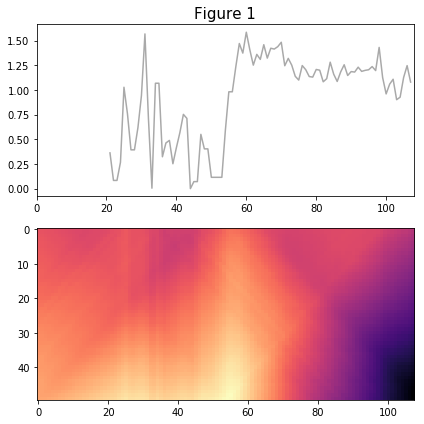

In [467]:
windows = np.linspace(21, 108, 50)  # 100 windows, equally spaced from width 10 to 1000
kernel = kernel_functions.power_law_zero_cusp  # a symmetric power-law type cusp
k_args = [0.25] # arguments for the kernel; in this case, it's the parameter $\theta = 3$.
reflection = 0 # reflect the kernel over the horizontal axis

dst, largest_kernel = shocklets.cusplet(
    x,
    windows,
    kernel_func=kernel,
    kernel_args=k_args,
    reflection=reflection
)

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
ax0, ax1 = axes
ax0.plot(x, 'darkgray')
ax0.set_xlim(0, len(x))
im = ax1.imshow(
    dst,
    aspect='auto',
    cmap=plt.cm.magma,
)

ax0.set_title('Figure 1', fontsize=15);
plt.tight_layout()

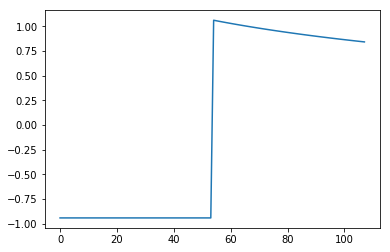

In [476]:
plt.plot(largest_kernel)

Text(0.5,1,'NYC Transit $-$ Shocklet Detection')

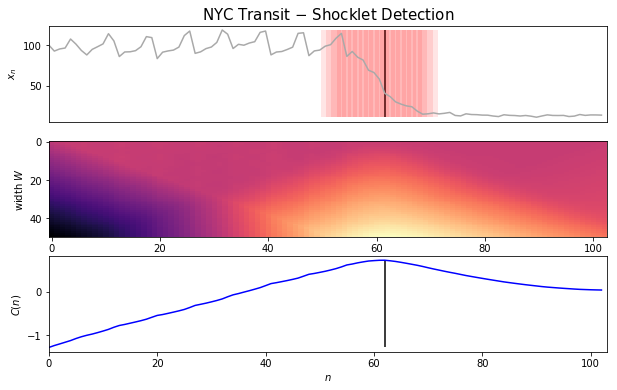

In [9]:
# extrema are the estimated extrema of the hypothesized underlying dynamics
# indicator is the cusplet indicator function, plotted below in a blue curve
# geval are indices of the cusplet indicator function where it exceeds geval
# b is a sensitivity parameter; higher b is less sensitive. 
extrema, indicator, gepoints = shocklets.classify_cusps( dst, b=.5, geval=.5 )
# now we can get and plot contiguous windows of cusp-y behavior
# these are created from the gepoints 
windows = shocklets.make_components(gepoints)

fig, axes = plt.subplots(3, 1, figsize=(10, 6))
ax, ax2, ax3 = axes

ax.plot(x, 'darkgray')
ax.vlines(extrema, min(x), max(x))
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlim(0, len(x))

# annotate the windows
for window in windows:
    ax.vlines(window, min(x), max(x), alpha=0.1, color='r',lw=20,)

ax3.plot(indicator, 'b-')
ax3.vlines(extrema,  min(indicator), max(indicator), )
ax3.set_xlim(0, len(x))

ax.set_ylabel('$x_n$')
ax3.set_xlabel('$n$')
ax3.set_ylabel('$C(n)$')

im = ax2.imshow(
    dst,
    aspect='auto',
    cmap=plt.cm.magma,
)

ax2.set_ylabel('width $W$')

#ax2.colorbar(im)

ax.set_title('NYC Transit $-$ Shocklet Detection', fontsize=15)
#plt.savefig('../figures/NYC_Transit_Shocklet.pdf')
#plt.savefig('../figures/NYC_Transit_Shocklet.png',dpi=300)

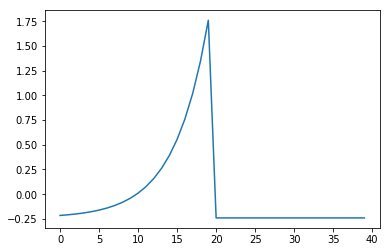

In [153]:
plt.plot(kernel_functions.exp_zero_cusp(40,3))

### Run Shocklet on All Transit

In [434]:
windows = np.linspace(5, 103, 50)  # 100 windows, equally spaced from width 10 to 1000
kernel = kernel_functions.power_law_zero_cusp  # a symmetric power-law type cusp
k_args = [0.]  # arguments for the kernel; in this case, it's the parameter $\theta = 3$.
reflection = 2  # reflect the kernel over the horizontal axis

In [477]:
def get_shock_ind(x,windows=windows,
        kernel_func=kernel,
        kernel_args=k_args,
        reflection=reflection,
                 b=0.9,
                 geval=0.25):
    """Run shocklet with globally defined parameters"""
    dst, largest_kernel = shocklets.cusplet(
        x,
        windows,
        kernel_func=kernel,
        kernel_args=k_args,
        reflection=reflection
    )

    extrema, indicator, gepoints = shocklets.classify_cusps( dst, b=b, geval=geval )
    return (extrema, indicator, gepoints)

In [436]:
#get_shock_ind(x.astype(float))

In [437]:
transit_inds = {col:get_shock_ind(top5[col].astype(float).values) for col in top5.columns}

In [440]:
[x[0] for x in transit_inds.values()]

[[62, 64, 68],
 [62, 64],
 [62],
 [62],
 [60],
 [62],
 [62, 64],
 [62],
 [63],
 [62],
 [61],
 [59, 62],
 [62],
 [62],
 [62]]

### Run Shocklet on Mobility

In [343]:
top5.head()

region              Chicago                 Los Angeles                  \
transportation_type driving transit walking     driving transit walking   
2020-01-13              100     100     100         100     100     100   
2020-01-14           103.68  100.93  104.58      105.93  103.78  105.72   
2020-01-15           104.45  100.61   107.2      112.23  105.28  111.35   
2020-01-16           108.72  103.79  104.82      111.73  103.12  111.68   
2020-01-17            132.8  120.72  128.05       130.2  109.34  134.45   

region              New York City                  
transportation_type       driving transit walking  
2020-01-13                    100     100     100  
2020-01-14                 101.51   92.66   96.09  
2020-01-15                 104.51   95.29  105.77  
2020-01-16                 108.78   96.42  101.73  
2020-01-17                 122.44   107.5  117.09

In [129]:
our_mat = np.zeros(top5.T.shape)

In [130]:
for i,v in enumerate( transit_inds.values()):
    inds = v[2]
    vals = v[1][inds]
    our_mat[i][inds]=vals 

64 0 0.5
62 1 1.5
63 2 2.5
62 3 3.5
61 4 4.5
62 5 5.5
62 6 6.5
62 7 7.5
62 8 8.5


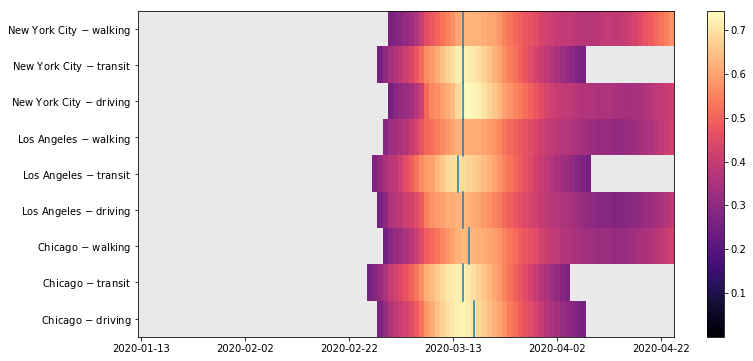

In [140]:
f,a = plt.subplots(1,1,figsize=(12,6))

im = a.imshow(
    our_mat,
    aspect='auto',
    cmap=plt.cm.magma,
    vmin=.0001
)
im.cmap.set_under('lightgrey',alpha=.5)


plt.colorbar(im,)
a.set_yticks(np.arange(9)[::-1])
a.set_yticklabels([x[0]  + ' $-$ ' + x[1] for x in transit_inds.keys()])

for i,v in enumerate( transit_inds.values()):
    print(v[0][-1],i,i+.5)
    a.axvline(v[0][-1],i/9, ((i+1)/9))
a.set_xticks(np.arange(0,101,20))
a.set_xticklabels(top5.index[np.arange(0,101,20)])
#a.text(.9,.5, "CIF",rotation=90)
#a2=a.twinx()
#a2.plot(top5)
#plt.savefig('../figures/Shocklet_Mobility.pdf',bbox_inches='tight')
#plt.savefig('../figures/Shocklet_Mobility.png',bbox_inches='tight',dpi=300)

#### Before and After Shock Change

In [453]:
top5.iloc[62:].mean() - top5.iloc[:62].mean()

region         transportation_type
Atlanta        driving               -50.056216
               transit               -48.179575
               walking               -52.214933
Boston         driving               -58.478245
               transit               -83.073942
               walking               -79.078603
Chicago        driving               -54.408057
               transit               -77.058029
               walking               -72.187982
Los Angeles    driving               -64.792400
               transit               -76.686330
               walking               -71.298592
New York City  driving               -60.929654
               transit               -80.836058
               walking               -82.203588
dtype: float64

### Run on Rank Divergence

In [468]:
def city_ngrams(inputdir, city_name, target_list):
    """ Get a dataframe with the target list of ngrams
    """
    comments_loc = Path(inputdir)
    date2rank = {}
    for file in sorted(comments_loc.glob(f'{city_name}*/*')):
        print(file,end='\r')
        temp_df = pd.read_csv(file,sep='\t')
        temp_df.Ngram = temp_df.Ngram.astype(str)
        temp_df['Date'] = file.stem
        #date2rank.update({file.stem:temp_df[temp_df['Ngram'].str.contains(target)]})
        date2rank.update({file.stem:temp_df[temp_df['Ngram'].isin(target_list)]})
    new_res = pd.concat(date2rank.values())
    sm_df = new_res.pivot(index='Date', columns='Ngram',values='rank')
    sm_df.index = pd.to_datetime(sm_df.index)
    return sm_df

In [553]:
topn_1grams = ['cuomo','virus','coronavirus','covid19','masks','pandemic','quarantine','symptoms','flu','distancing','lockdown','testing','n95','hospitals']

In [554]:
sm_df = city_ngrams('../data/reddit_data_0418/ngrams/1grams/', 'NYC', topn_1grams)

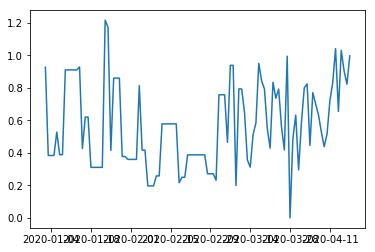

In [563]:
x = np.log10(sm_df['cuomo'].fillna(method='pad'))

x*=-1
x-= x.min()
#plt.plot(pd.DataFrame(x).rolling(14,center=True,).mean())
plt.plot(x)

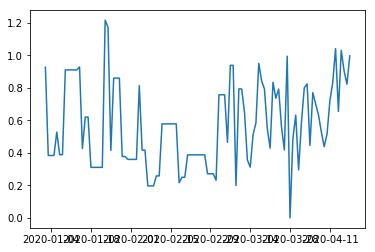

In [564]:
plt.plot(x)

In [565]:
windows = np.linspace(7, 103, 50)  # 100 windows, equally spaced from width 10 to 1000
kernel = kernel_functions.power_law_zero_cusp  # a symmetric power-law type cusp
k_args = [0.25] # arguments for the kernel; in this case, it's the parameter $\theta = 3$.
reflection = 0  # reflect the kernel over the horizontal axis

Text(0,0.5,'width $W$')

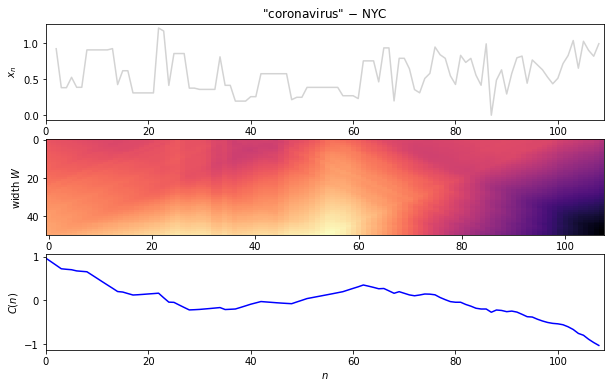

In [566]:
(extrema, indicator, gepoints) = get_shock_ind(x,b=1.2,geval=.5)

fig, axes = plt.subplots(3, 1, figsize=(10, 6))
ax, ax2, ax3 = axes

ax.plot(np.arange(x.shape[0]),x, 'lightgrey')
ax.vlines(extrema, min(x), max(x))
#ax.set_xticks([])
#ax.set_xticklabels([])
ax.set_xlim(0, len(x))

# annotate the windows
for window in windows:
    ax.vlines(window, min(x), max(x), alpha=0.1, color='r',lw=20,)

ax3.plot(indicator, 'b-')
ax3.vlines(extrema,  min(indicator), max(indicator), )
ax3.set_xlim(0, len(x))

ax.set_ylabel('$x_n$')
ax3.set_xlabel('$n$')
ax3.set_ylabel('$C(n)$')

im = ax2.imshow(
    dst,
    aspect='auto',
    cmap=plt.cm.magma,
)

ax.set_title('"coronavirus" $-$ NYC')
ax2.set_ylabel('width $W$')
#plt.savefig('../figures/cuspindicator_coronavirus.pdf')
#plt.savefig('../figures/cuspindicator_coronavirus.png',dpi=300)

#### Load Rank Div

In [636]:
rank_div_loc = Path('../data/reddit_data_0418/rank_div/')
city2rankdiv = {}
for file in rank_div_loc.glob('*'):
    city2rankdiv.update({file.stem.split('_')[0]:pd.read_csv(file,sep='\t',header=None).head(1000)})

In [637]:
city2wordshock = {}
for key,val in city2rankdiv.items():
    word2shock = {}
    sm_df = city_ngrams('../data/reddit_data_0418/ngrams/1grams/', key, val[0])
    word2rank = {v:k for k,v in val.to_dict()[0].items()}
    for i,col in enumerate(sm_df.columns):
        x = np.log10(sm_df[col].fillna(method='pad'))
        x*=-1
        x-= x.min()
        #print(i,col)
        word2shock.update({col: (word2rank[col],get_shock_ind(x,b=1.2,geval=.5))})
    city2wordshock.update({key:word2shock})

In [616]:
np.where(city2wordshock['NYC']['CDC'][1]==city2wordshock['NYC']['CDC'][1].max())

AttributeError: 'tuple' object has no attribute 'max'

In [617]:
city2wordshock['NYC']['CDC'][0]

62

In [633]:
#plt.hist([np.where(x[1][1]==x[1][1].max()) for x in city2wordshock['NYC'].values() if x[1][0] and vals[1][0]>15])

(array([ 1.,  0.,  0.,  0.,  1.,  0., 14., 15.,  4.,  4.]),
 array([18. , 23.6, 29.2, 34.8, 40.4, 46. , 51.6, 57.2, 62.8, 68.4, 74. ]),
 <a list of 10 Patch objects>)

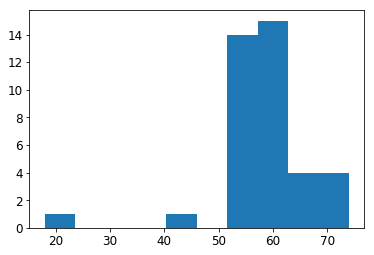

In [622]:
plt.hist([min(x[1][0]) for x in city2wordshock['NYC'].values() if x[1][0] and min(x[1][0])>15])

In [568]:
[(word,vals[0],min(vals[1][0])) for word,vals in city2wordshock['NYC'].items() if vals[1][0]]

[('$2.75', 235, 12),
 ('125th', 593, 8),
 ('2008', 509, 10),
 ('2017', 762, 12),
 ('42nd', 640, 7),
 ('80', 329, 7),
 ('African', 859, 8),
 ('AirTrain', 893, 13),
 ('Bagels', 686, 3),
 ('Black', 298, 14),
 ('CDC', 62, 44),
 ('COVID-19', 26, 59),
 ('Channel', 833, 20),
 ('Corona', 135, 56),
 ('Coronavirus', 112, 58),
 ("Cuomo's", 421, 12),
 ('Dallas', 784, 10),
 ('Denver', 905, 22),
 ('Dominican', 435, 16),
 ('EMS', 475, 8),
 ('English', 212, 11),
 ('FDA', 605, 59),
 ('Fresh', 557, 22),
 ('GPS', 647, 8),
 ('Government', 831, 8),
 ('Harris', 445, 4),
 ('Health', 320, 59),
 ('Hudson', 514, 1),
 ('I', 401, 5),
 ('ICU', 104, 62),
 ('India', 556, 24),
 ('Iranian', 40, 3),
 ('Italy', 60, 59),
 ('Jeffrey', 877, 4),
 ('Korea', 796, 58),
 ('LGA', 412, 11),
 ('LIRR', 781, 2),
 ('Landlords', 327, 4),
 ('MTA', 41, 5),
 ('Manhattan', 726, 15),
 ('Marx', 832, 87),
 ('Mets', 50, 15),
 ('Ms', 846, 11),
 ('NO', 594, 9),
 ('Newark', 868, 4),
 ('Nick', 699, 53),
 ('North', 821, 3),
 ('OMNY', 689, 1),
 ('P

##### Rank Onset

In [569]:
#rankvshock = pd.DataFrame([(val[0],np.where(val[1][1]==val[1][1].max())[0][0]) for val in city2wordshock['NYC'].values() if val[1][0]])

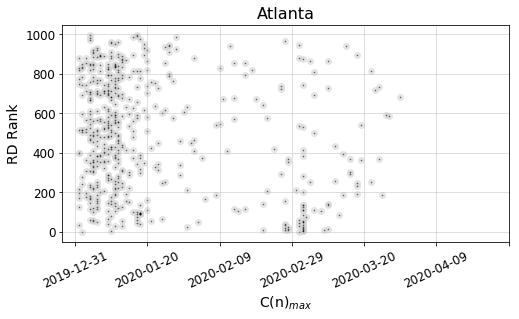

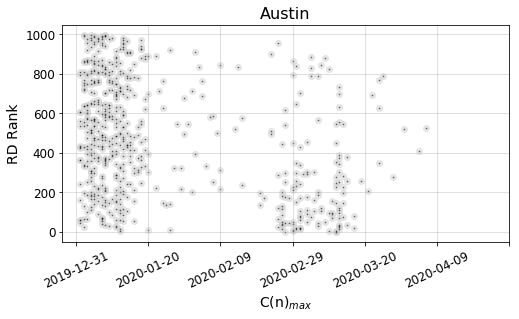

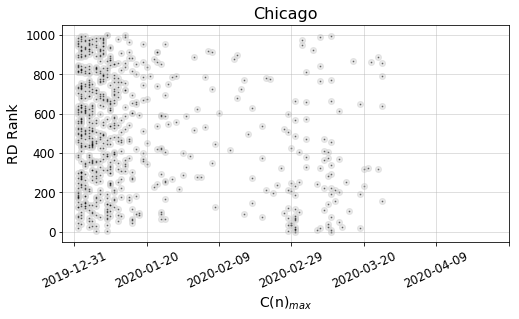

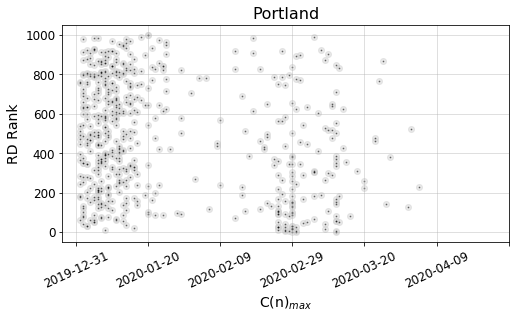

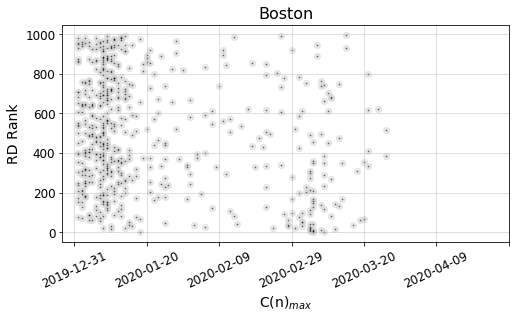

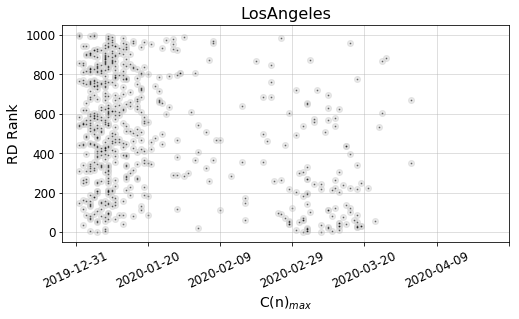

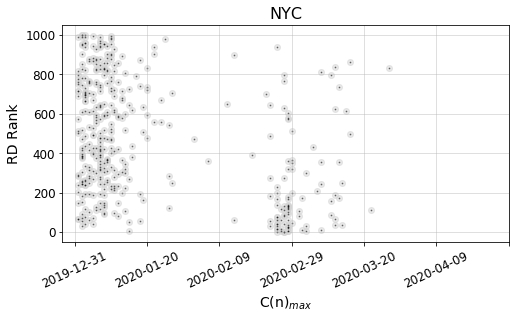

In [643]:
for city in city2wordshock.keys():
    rankvshock = pd.DataFrame([(val[0],min(val[1][0])) for val in city2wordshock[city].values() if val[1][0]])
    f,a = plt.subplots(1,1,figsize=(8,4))
    plt.scatter(rankvshock[1],rankvshock[0],alpha=.5, marker='o',color='lightgrey')
    plt.scatter(rankvshock[1],rankvshock[0],alpha=.5, marker='.',color='k',s=2)
    #plt.scatter(rankvshock[1],rankvshock[0],alpha=.5, marker='o',color)
    plt.xticks(np.arange(0,121,20))
    plt.xticks(rotation=25)
    plt.xlabel("C(n)$_{max}$")
    plt.ylabel("RD Rank")
    a.set_xticklabels(sm_df.index[np.arange(0,111,20)].date)
    #a.xaxis.set_major_locator(major_locator)
    #a.xaxis.set_major_formatter(mdates.DateFormatter(date_format))
    #a.xaxis.set_minor_locator(minor_locator)
    plt.grid(alpha=.5)
    plt.title(city)
    plt.savefig(f'../figures/{city}_rank_div_cusp.pdf',bbox_inches='tight')
    plt.savefig(f'../figures/{city}_rank_div_cusp.png',bbox_inches='tight',dpi=300)

In [595]:
sm_df.index[60]

Timestamp('2020-02-29 00:00:00')

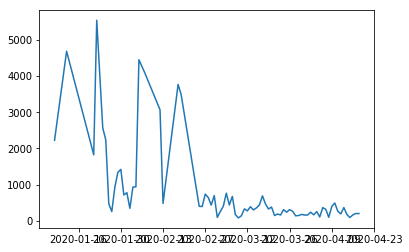

In [499]:
plt.plot(city_ngrams('../data/reddit_data_0418/ngrams/1grams/', 'NYC', ['masks']))

In [679]:
city2meanonset = {}
for k,v in city2wordshock.items():
    #for val in v.values():
        #if val[1][0]:
            #print(val[1][0])
       
    city2meanonset.update({k:[min(val[1][0]) for val in v.values() if val[1][0] and min(val[1][0]) > 25 ]})

In [702]:
city2meanonset = {k:city2meanonset[k] for k in reddit2apple.keys()}

In [705]:
list(city2meanonset.keys())

['NYC', 'LosAngeles', 'Boston', 'Chicago', 'Atlanta']

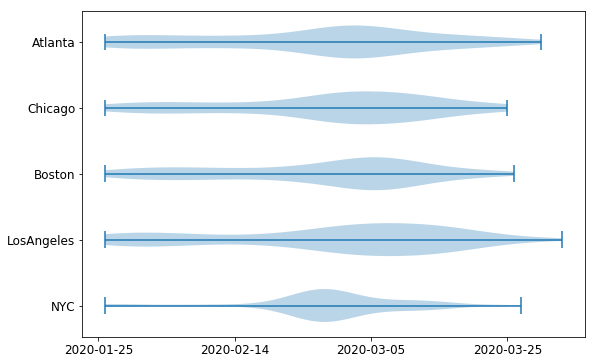

In [722]:
f,a=plt.subplots(1,1,figsize=(9,6))
plt.violinplot(list(city2meanonset.values()),vert=False)
plt.yticks(np.arange(1,6))
plt.xticks(np.arange(25,100,20))
a.set_yticklabels(list(city2meanonset.keys()))
a.set_xticklabels(sm_df.index[np.arange(25,100,20)].date)
plt.savefig('../figures/city_ngram_shock.pdf',bbox_inches='tight')
plt.savefig('../figures/city_ngram_shock.png',bbox_inches='tight',dpi=300)

In [674]:
reduction_df = pd.DataFrame(top5.iloc[62:].mean() - top5.iloc[:62].mean()).T

In [675]:
reduction_df

region                 Atlanta                           Boston             \
transportation_type    driving    transit    walking    driving    transit   
0                   -50.056216 -48.179575 -52.214933 -58.478245 -83.073942   

region                            Chicago                       Los Angeles  \
transportation_type    walking    driving    transit    walking     driving   
0                   -79.078603 -54.408057 -77.058029 -72.187982    -64.7924   

region                                   New York City                        
transportation_type   transit    walking       driving    transit    walking  
0                   -76.68633 -71.298592    -60.929654 -80.836058 -82.203588

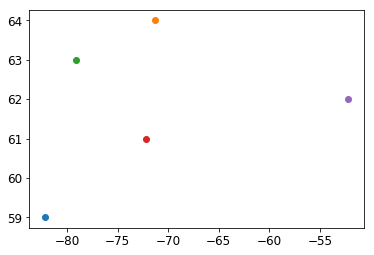

In [678]:
for key, val in reddit2apple.items():
    #for col in reduction_df[val].columns:
    plt.scatter(reduction_df[val]['walking'], city2meanonset[key])